In [1]:
import numpy as np
import pandas as pd
import artist_info_helper as aih

import glob, os, re, sys
from datetime import datetime
import pickle
import time
import copy
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('mpl_style_Jeffreson.mplstyle')
def percent_formatter(x, pos):
    return f'{x*100:.1f}\%'
def log_format(x, pos):
    return f'{int(x)}'

from wordcloud import WordCloud

# clean random artists collected

In [42]:
DEFAULT_RND_DIR = "/n/holystore01/LABS/itc_lab/Users/sjeffreson/serch/artist-database/"
df = pd.read_csv(DEFAULT_RND_DIR + "Spotify_artist_info_Mnth-Lstnrs.csv")
print(df.columns)
df.describe()

Index(['ids', 'names', 'popularity', 'followers', 'genres', 'first_release',
       'last_release', 'num_releases', 'num_tracks', 'monthly_listeners'],
      dtype='object')


,popularity,followers,first_release,last_release,num_releases,num_tracks,monthly_listeners
count,25243.000000,2.524300e+04,25243.000000,25243.000000,25243.000000,25243.000000,2.523900e+04
mean,9.932298,3.703832e+04,1686.301707,1693.413263,6.145823,5.189280,1.068901e+05
std,14.462925,4.913148e+05,738.036745,741.098593,6.678190,11.696343,1.095137e+06
min,0.000000,0.000000e+00,-1.000000,-1.000000,0.000000,0.000000,0.000000e+00
25%,0.000000,3.200000e+01,1995.000000,2008.000000,1.000000,1.000000,2.300000e+01
50%,2.000000,2.150000e+02,2010.000000,2019.000000,3.000000,2.000000,2.780000e+02
75%,15.000000,1.806500e+03,2017.000000,2023.000000,9.000000,6.000000,4.951500e+03
max,88.000000,3.405974e+07,2024.000000,2024.000000,20.000000,810.000000,6.784168e+07


In [43]:
# uh oh! Most of this removal is due to genres. We need to find a way to attach genres to artists
# that have no genre.
features = ['genres']
df_negtracks = df.dropna(subset=[column for column in df.columns if column in features])
df_negtracks = df_negtracks.drop(df_negtracks[(df_negtracks[features] == -1).any(axis=1)].index)
print(len(df_negtracks['num_tracks']))

8738


In [44]:
# we don't need the popularity or followers counts (we have Monthly Listeners), but everything
# else should be present, and indicates a problem if it's not (artists should have releases and
# tracks, and information about these). Therefore drop any rows with -1 values or NaNs in these
# columns (we assigned -1 to missing values in the data collection process).
features = ['first_release', 'last_release', 'num_releases', 'num_tracks', 'monthly_listeners', 'genres']
df = df.dropna(subset=[column for column in df.columns if column in features])
df = df.drop(df[(df[features] == -1).any(axis=1)].index)
#df = df.drop(df[df['monthly_listeners'] == 0].index)
df.describe()

,popularity,followers,first_release,last_release,num_releases,num_tracks,monthly_listeners
count,8387.000000,8.387000e+03,8387.000000,8387.000000,8387.000000,8387.000000,8.387000e+03
mean,20.332896,1.092142e+05,2006.392155,2018.771909,10.334088,5.730416,3.017510e+05
std,17.556371,8.476963e+05,13.505275,7.633092,7.134645,11.956493,1.878761e+06
min,0.000000,2.000000e+00,1899.000000,1930.000000,1.000000,1.000000,0.000000e+00
25%,5.000000,6.845000e+02,2001.000000,2017.000000,4.000000,1.000000,7.225000e+02
50%,17.000000,3.227000e+03,2010.000000,2022.000000,9.000000,3.000000,7.040000e+03
75%,32.000000,1.763600e+04,2016.000000,2023.000000,20.000000,8.000000,5.564300e+04
max,88.000000,3.405974e+07,2024.000000,2024.000000,20.000000,810.000000,6.784168e+07


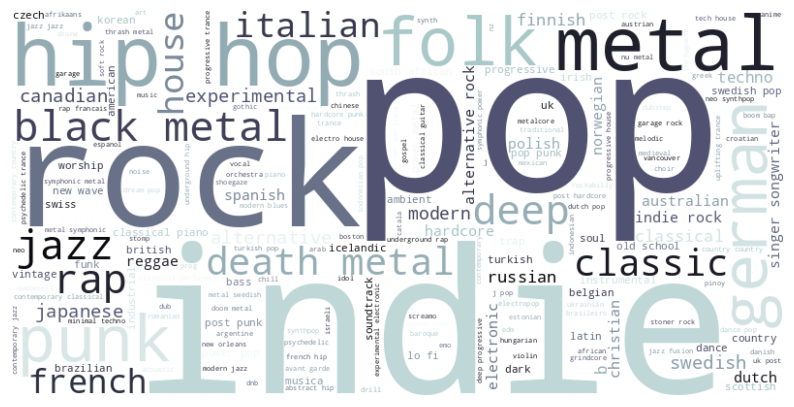

In [45]:
# another important thing to check is the pool of genres we have here, as this is a categorical
# variable, and it's possible that some genres need to be treated separately, due to very different
# listenership demographics that don't overlap with the other genres (e.g. classical music, traditional
# music, lo-fi, i.e. anything that is often used as background music).

# flatten all genres into a single string
genre_string = " ".join(df['genres'].str.cat(sep=" ").split(", "))
genre_string = re.sub(r'\s+', ' ', genre_string)

# word-cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap=plt.cm.bone).generate(genre_string)

# Display the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.savefig("/n/holystore01/LABS/itc_lab/Users/sjeffreson/serch/figs/wordcloud.png",
            format='png', bbox_inches='tight', dpi=200)
plt.show()

In [46]:
# a non-exhaustive list of genres is: Blues, Brass & Military, Children's, Classical, Electronic/EDM, Folk & traditional,
# Country, Funk, Soul, Hip-Hop, Jazz, Latin, Pop, Reggae, Metal, Rock, Soundtracks/Stage & Screen, R&B, Rap, Religious, Newage

# Let's just take the most common genres from the word cloud, excluding classical, folk & traditional, lo-fi: any genre list
# that contains the words: "pop", "rock", "indie", "hip hop", "punk", "rap", "electronic", "metal", "house", "jazz"
gnrslct = ["pop", "rock", "indie", "hip hop", "punk", "rap", "electro", "metal",
           "house", "jazz", "blues", "reggae", "latin", "tech",
           "country", "funk", "soul", "latin", "songwriter", "dance"]
pattern = '|'.join(gnrslct)
df_gnrslct = df[df['genres'].str.contains(pattern)]
df_gnrslct.describe()

,popularity,followers,first_release,last_release,num_releases,num_tracks,monthly_listeners
count,5252.000000,5.252000e+03,5252.000000,5252.000000,5252.000000,5252.000000,5.252000e+03
mean,21.463633,1.426517e+05,2007.078256,2019.219916,10.640327,4.526657,3.913863e+05
std,18.416105,9.768580e+05,12.941578,7.108097,7.106336,5.205934,2.266796e+06
min,0.000000,2.000000e+00,1899.000000,1953.000000,1.000000,1.000000,0.000000e+00
25%,5.000000,9.652500e+02,2003.000000,2018.000000,4.000000,1.000000,7.007500e+02
50%,18.000000,4.802500e+03,2011.000000,2022.000000,9.000000,2.000000,8.778500e+03
75%,34.000000,2.714550e+04,2016.000000,2023.000000,20.000000,6.000000,7.348075e+04
max,88.000000,3.405974e+07,2024.000000,2024.000000,20.000000,59.000000,6.784168e+07


In [47]:
print(df.loc[df['first_release'].idxmin()])

ids                                6nLkWu5DSXItXcB6q2ISTO
names                              gerry mulligan quartet
popularity                                             40
followers                                           21294
genres               bebop, cool jazz, jazz, jazz quartet
first_release                                        1899
last_release                                         2022
num_releases                                           18
num_tracks                                              7
monthly_listeners                                203960.0
Name: 5352, dtype: object


# same cleaning for the featured artists

In [65]:
del df_edits

In [66]:
DEFAULT_EDITORIAL_DIR = "/n/holystore01/LABS/itc_lab/Users/sjeffreson/serch/artist-database/Editorial-playlists/"
names = glob.glob(DEFAULT_EDITORIAL_DIR + "artists_last_24hrs_*_info.csv")
for name in names:
    df_edit = pd.read_csv(name)
    if 'df_edits' in locals():
        df_edits = pd.concat([df_edits, df_edit])
    else:
        df_edits = df_edit
print(len(df_edits))

13821


In [67]:
# uh oh! Most of this removal is due to genres. We need to find a way to attach genres to artists
# that have no genre.
features = ['genres']
df_edits_negtracks = df_edits.dropna(subset=[column for column in df_edits.columns if column in features])
df_edits_negtracks = df_edits_negtracks.drop(df_edits_negtracks[(df_edits_negtracks[features] == -1).any(axis=1)].index)
print(len(df_edits_negtracks))

9442


In [68]:
features = ['first_release', 'last_release', 'num_releases', 'num_tracks', 'monthly_listeners', 'genres']
df_edits = df_edits.dropna(subset=[column for column in df_edits.columns if column in features])
df_edits = df_edits.drop(df_edits[(df_edits[features] == -1).any(axis=1)].index)
df_edits.describe()

,monthly_listeners,popularity,followers,first_release,last_release,num_releases,num_tracks
count,9.392000e+03,9392.00000,9.392000e+03,9392.000000,9392.000000,9392.000000,9392.000000
mean,8.271088e+06,57.18026,3.334511e+06,2011.551214,2023.188565,17.169719,2.802066
std,1.468409e+07,17.12880,9.920761e+06,42.988647,2.276655,4.864028,4.294467
min,0.000000e+00,3.00000,9.000000e+00,0.000000,1972.000000,1.000000,1.000000
25%,2.940590e+05,44.00000,2.979800e+04,2009.000000,2023.000000,15.000000,1.000000
50%,1.711754e+06,58.00000,2.513920e+05,2016.000000,2024.000000,20.000000,1.000000
75%,9.233074e+06,70.00000,1.949412e+06,2020.000000,2024.000000,20.000000,3.000000
max,1.135538e+08,100.00000,1.137957e+08,2024.000000,2024.000000,20.000000,80.000000


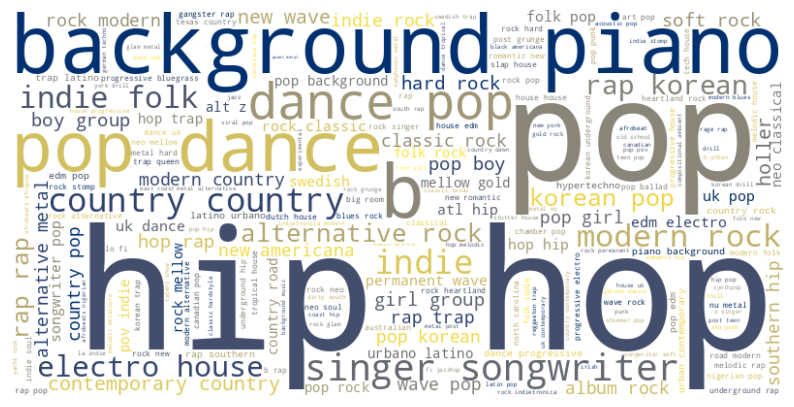

In [69]:
# flatten all genres into a single string
genre_string = " ".join(df_edits['genres'].str.cat(sep=" ").split(", "))
genre_string = re.sub(r'\s+', ' ', genre_string)

# word-cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap=plt.cm.cividis).generate(genre_string)

# Display the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.savefig("/n/holystore01/LABS/itc_lab/Users/sjeffreson/serch/figs/wordcloud-featured.png",
            format='png', bbox_inches='tight', dpi=200)
plt.show()

In [70]:
pattern = '|'.join(gnrslct)
df_edits_gnrslct = df_edits[df_edits['genres'].str.contains(pattern)]
df_edits_gnrslct.describe()

,monthly_listeners,popularity,followers,first_release,last_release,num_releases,num_tracks
count,7.325000e+03,7325.000000,7.325000e+03,7325.000000,7325.000000,7325.000000,7325.000000
mean,1.007049e+07,60.323413,4.182430e+06,2011.117543,2023.115631,17.812287,2.890785
std,1.595413e+07,16.624433,1.105140e+07,11.537533,2.375550,4.341997,4.218866
min,0.000000e+00,3.000000,9.000000e+00,1954.000000,1972.000000,1.000000,1.000000
25%,5.070910e+05,49.000000,8.299000e+04,2008.000000,2023.000000,18.000000,1.000000
50%,3.106762e+06,62.000000,5.539570e+05,2015.000000,2024.000000,20.000000,1.000000
75%,1.213560e+07,73.000000,3.041597e+06,2019.000000,2024.000000,20.000000,3.000000
max,1.135538e+08,100.000000,1.137957e+08,2024.000000,2024.000000,20.000000,80.000000


# plot the Monthly Listener distributions

In [53]:
ds = pd.Series(df_gnrslct['monthly_listeners'])
ds_edits = pd.Series(df_edits_gnrslct['monthly_listeners'])

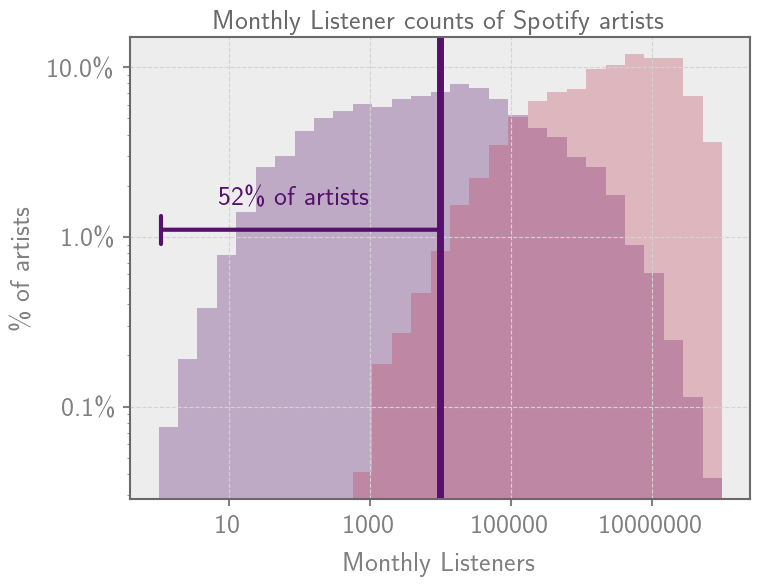

In [54]:
plt.figure(figsize=(8, 6))

# plot data
weights = np.ones_like(ds) / len(ds)
plt.hist(ds, bins=np.logspace(0., 8., 30), weights=weights,
         alpha=0.3, lw=2, log=True, color=plt.cm.inferno(0.25))
weights_edits = np.ones_like(ds_edits) / len(ds_edits)
plt.hist(ds_edits, bins=np.logspace(0., 8., 30), weights=weights_edits,
         alpha=0.3, lw=2, log=True, color=plt.cm.inferno(0.5))

# percentile rank below 10000
plt.axvline(10000., color=plt.cm.inferno(0.25), lw=5)
percentage_below = ((ds < 10000.).mean() * 100).round().astype(int)
plt.annotate(f'{percentage_below}\% of artists', xy=(1000., 0.02), xytext=(1000., 0.02),
             va='top', ha='right', color=plt.cm.inferno(0.25))
plt.annotate('',
    xy=(1., 0.011), xytext=(10000., 0.011),
    arrowprops=dict(arrowstyle="|-|,widthA=0.,widthB=0.5", facecolor=plt.cm.inferno(0.25), edgecolor=plt.cm.inferno(0.25), lw=3),
)

plt.xscale('log')
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(percent_formatter))
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(log_format))

plt.title(r'Monthly Listener counts of Spotify artists', color='dimgrey')
plt.xlabel(r'Monthly Listeners')
plt.ylabel(r'\% of artists')
plt.ylim([plt.gca().get_ylim()[0], 0.15])

# plt.savefig("/n/holystore01/LABS/itc_lab/Users/sjeffreson/serch/figs/total_dstbn.png",
#             format='png', bbox_inches='tight', dpi=200)
plt.show()

# separate out active artists

In [18]:
active_artists = aih.get_active_artists(df_gnrslct)
ds_active = pd.Series(active_artists['monthly_listeners'])
ds_active = ds_active[ds_active>0]
print(len(ds_active))

83


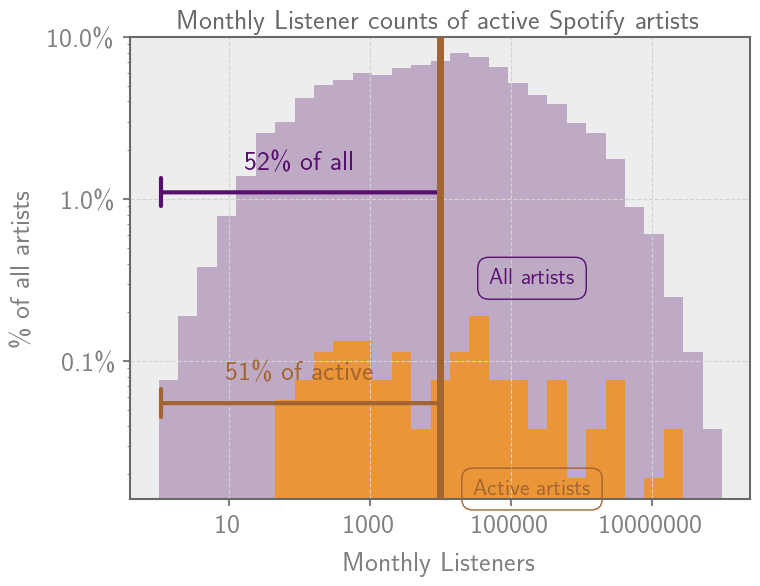

In [19]:
plt.figure(figsize=(8, 6))

# plot data
weights = np.ones_like(ds) / len(ds)
plt.hist(ds, bins=np.logspace(0., 8., 30), weights=weights,
         alpha=0.3, lw=2, log=True, color=plt.cm.inferno(0.25))
weights = np.ones_like(ds_active) / len(ds)
plt.hist(ds_active,
         bins=np.logspace(0., 8., 30), weights=weights,
         alpha=0.75, lw=2, log=True, color=plt.cm.inferno(0.75))

# percentile rank below 10000, all
percentage_below = ((ds < 10000.).mean() * 100).round().astype(int)
plt.annotate(f'{percentage_below}\% of all', xy=(100., 0.02), xytext=(100., 0.02),
             va='top', ha='center', color=plt.cm.inferno(0.25))
plt.annotate('',
    xy=(1., 0.011), xytext=(10000., 0.011),
    arrowprops=dict(arrowstyle="|-|,widthA=0.,widthB=0.5", facecolor=plt.cm.inferno(0.25), edgecolor=plt.cm.inferno(0.25), lw=3),
)

# percentile rank below 10000, active
plt.axvline(10000., color="#A26531", lw=5, zorder=5)
percentage_below = ((ds_active < 10000.).mean() * 100).round().astype(int)
plt.annotate(f'{percentage_below}\% of active', xy=(100., 0.001), xytext=(100., 0.001),
             va='top', ha='center', color="#A26531")
plt.annotate('',
    xy=(1., 0.00055), xytext=(10000., 0.00055),
    arrowprops=dict(arrowstyle="|-|,widthA=0.,widthB=0.5", facecolor="#A26531", edgecolor="#A26531", lw=3),
)

# annotation of all vs. active artists
plt.annotate('All artists', xy=(2e5, 0.003), xytext=(2e5, 0.003), color=plt.cm.inferno(0.25), ha='center', fontsize=16,
             bbox=dict(boxstyle='round,pad=0.5', facecolor='None', edgecolor=plt.cm.inferno(0.25)))
plt.annotate('Active artists', xy=(2e5, 0.00015), xytext=(2e5, 0.00015), color="#A26531", ha='center', fontsize=16,
             bbox=dict(boxstyle='round,pad=0.5', facecolor='None', edgecolor="#A26531"))

plt.xscale('log')
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(percent_formatter))
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(log_format))

plt.title(r'Monthly Listener counts of active Spotify artists', color='dimgrey')
plt.xlabel(r'Monthly Listeners')
plt.ylabel(r'\% of all artists')
plt.ylim([plt.gca().get_ylim()[0], 0.1])

# plt.savefig("/n/holystore01/LABS/itc_lab/Users/sjeffreson/serch/figs/total_active_dstbn.png",
#             format='png', bbox_inches='tight', dpi=200)

plt.show()